In [1]:
import torch
import torch.nn as nn
from NARX import NARX
from ANARX import ANARX
import matplotlib.pyplot as plt
from tqdm import tqdm
from utilities import lag_matrix
from sysidentpy.utils.generate_data import get_siso_data


In [2]:
# model = ANARX(5, [1, 1])
# optim = torch.optim.Adam(model.parameters())
# crit = nn.MSELoss()
x_train, x_valid, y_train, y_valid = get_siso_data(n=1000,
                                                   colored_noise=False,
                                                   sigma=0.01,
                                                   train_percentage=80)

In [3]:
model2 = ANARX(2, [2], n_hidden=5, layersize= 20)

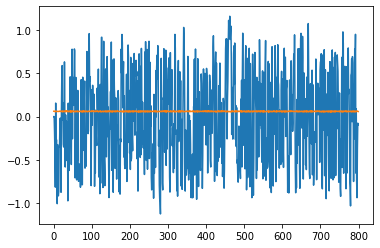

ANARX(
  (subnets): ModuleList(
    (0): LAGNET(
      (linear_layers): ModuleList(
        (0): Linear(in_features=2, out_features=20, bias=True)
        (1): Linear(in_features=20, out_features=20, bias=True)
        (2): Linear(in_features=20, out_features=20, bias=True)
        (3): Linear(in_features=20, out_features=20, bias=True)
        (4): Linear(in_features=20, out_features=1, bias=True)
      )
    )
    (1): LAGNET(
      (linear_layers): ModuleList(
        (0): Linear(in_features=2, out_features=20, bias=True)
        (1): Linear(in_features=20, out_features=20, bias=True)
        (2): Linear(in_features=20, out_features=20, bias=True)
        (3): Linear(in_features=20, out_features=20, bias=True)
        (4): Linear(in_features=20, out_features=1, bias=True)
      )
    )
  )
)


In [6]:
out = torch.Tensor(y_train).squeeze()
in1 = torch.Tensor(x_train).squeeze()
in1_lagged = lag_matrix(in1, 2)
out_lagged = lag_matrix(out, 2)

plt.plot(out.detach().numpy())
plt.plot(model2.predict([in1]).detach().numpy())
plt.show()
print(model2)

In [5]:
# Closed Loop Training
optim = torch.optim.Adam(model2.parameters())
crit = nn.MSELoss()
for i in tqdm(range(100)):
    optim.zero_grad()
    pred = model2.predict([in1])
    loss = crit(pred, out)
    loss.backward()
    optim.step()

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


In [5]:
# Open Loop Training
optim = torch.optim.Adam(model2.parameters())
crit = nn.MSELoss()
dataset = torch.utils.data.TensorDataset(in1_lagged, out_lagged, out)
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
for epoch in tqdm(range(1)):
    for i1, ol, os in loader:
        optim.zero_grad()
        loss = crit(model2(ol, [i1]), os.unsqueeze(dim=1))
        loss.backward()
        optim.step()

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\vh\anaconda3\envs\Projektmodul\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 1/1 [00:01<00:00,  1.91s/it]
